# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you find **at least two datasets** on the web which are related, and that you visualize these datasets to answer the assignment question. You are free to utilize datasets with any location or domain, the usage of **Ann Arbor sports and athletics** datasets in the example is just a suggestion.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * You must state a question you are seeking to answer with your visualizations.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together as an example! [Example Solution File](./readonly/Assignment4_example.pdf)

### Air Pollution vs. Fossil Power Trend in Taiwan (2019-2022)
Air pollution has become a pressing issue in Taiwan in recent years, particularly in central Taiwan, home to one of the largest fossil power plants in the world. This issue has also been a major point of contention in election campaigns. In our study, we examined the relationship between air pollution and fossil power generation to assess whether fossil power is the primary cause of pollution and to evaluate the effectiveness of current government efforts.

### Data Set Locations
* [Air Quality Station Data](https://data.moenv.gov.tw/en/dataset/detail/AQX_P_07)
* [Power Plant Data (Wikipedia)](https://en.wikipedia.org/wiki/List_of_power_stations_in_Taiwan)
* [Power Generation Data](https://data.gov.tw/en/datasets/112650)

### Process Flow
1. Find the nearest station to each fossil power plant.
2. Fetch station data using public database API
3.  Data visualization

### Find the nearest station to each fossil power plant.
#### Initialization & Helper Functions

In [1]:
import math
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# helper functions

def parse_coordinates(coord_string):
    """
    Parse the latitude and longitude coordinates in the format: "24°29′23.7″N 120°40′16″E".
    Returns latitude and longitude in decimal degrees.
    """
    pattern = r'(\d+)°(\d+)′([\d.]+)″([NS])\s+(\d+)°(\d+)′([\d.]+)″([EW])'
    match = re.match(pattern, coord_string)
    
    if match:
        lat_deg = int(match.group(1))
        lat_min = int(match.group(2))
        lat_sec = float(match.group(3))
        lat_dir = match.group(4)
        lon_deg = int(match.group(5))
        lon_min = int(match.group(6))
        lon_sec = float(match.group(7))
        lon_dir = match.group(8)
        
        lat_decimal = lat_deg + lat_min/60 + lat_sec/3600
        if lat_dir == 'S':
            lat_decimal = -lat_decimal
            
        lon_decimal = lon_deg + lon_min/60 + lon_sec/3600
        if lon_dir == 'W':
            lon_decimal = -lon_decimal
            
        return lat_decimal, lon_decimal
    
    else:
        return None

def parse_coordinates_pair(coords_str):  
    latitude, longitude = parse_coordinates(coords_str)
    return np.array((latitude, longitude))

def calculate_distance(coords_1, coords_2):
    """
    Calculate the distance between two coordinates using the Haversine formula.
    """
    # print(coords_1, coords_2)
 
    lat1, lon1 = coords_1
    lat2, lon2 = coords_2
    
    
    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = 6371 * c  # Radius of the Earth in kilometers
    
    return distance

def find_nearest_location(target_coords, coordinates):
    """
    Find the nearest location to the target coordinate from a set of coordinates.
    """
        
    min_distance = float('inf')
    nearest_location = None
    
    for coords in coordinates:
        distance = calculate_distance(target_coords, coords)
        if distance < min_distance:
            min_distance = distance
            nearest_location = coords
    
    return nearest_location, min_distance

def get_target_distance(coords_series, target_coord):
    distance = np.zeros_like(coords_series.to_numpy(copy=True))
    for i, c in enumerate(coords_series):
        distance[i] = calculate_distance(c, target_coord)

    return distance

# # Set of coordinates (latitude, longitude)
# coordinates = [
#     (37.7749, -122.4194),  # San Francisco
#     (34.0522, -118.2437),  # Los Angeles
#     (40.7128, -74.0060),   # New York
#     (51.5074, -0.1278)     # London
# ]

# # Target coordinate (latitude, longitude)
# target_coords = (51.5074, -0.1278)
# target_lat = 51.5074
# target_lon = -0.1278  # Chicago

# # Find the nearest location
# # nearest_location, distance = find_nearest_location(target_lat, target_lon, coordinates)
# nearest_location, distance = find_nearest_location(target_coords, coordinates)

# print("Nearest Location:", nearest_location)
# print("Distance:", distance, "km")

#### Load Station & Power Plant Data

In [2]:
# load station / power plant data
station_pos = pd.read_csv('.\\Station Locations.csv')
station_pos['Parsed Coords'] = station_pos.apply(lambda row: np.array((row['"twd97lat"'], row['"twd97lon"'])), axis=1)
plant_pos = pd.read_csv('.\\Power Plant Locations.csv')
plant_pos['Parsed Coords'] = plant_pos['Coordinates'].apply(parse_coordinates_pair)

#### Find the nearest station to each fossil power plant

In [3]:
# find the cloest station for each power plant

station_included = set()
plant_stations = {}

for i, plant in plant_pos.iterrows():
    station_distance = get_target_distance(station_pos['Parsed Coords'], plant['Parsed Coords'])
    station_nearby = np.argmin(station_distance)
    station_included.add(station_pos['"siteid"'][station_nearby])
    plant_stations[plant['Chinese']] = set()
    plant_stations[plant['Chinese']].add(station_pos['"siteid"'][station_nearby])



#### The plot confirms the location of the stations and power plants

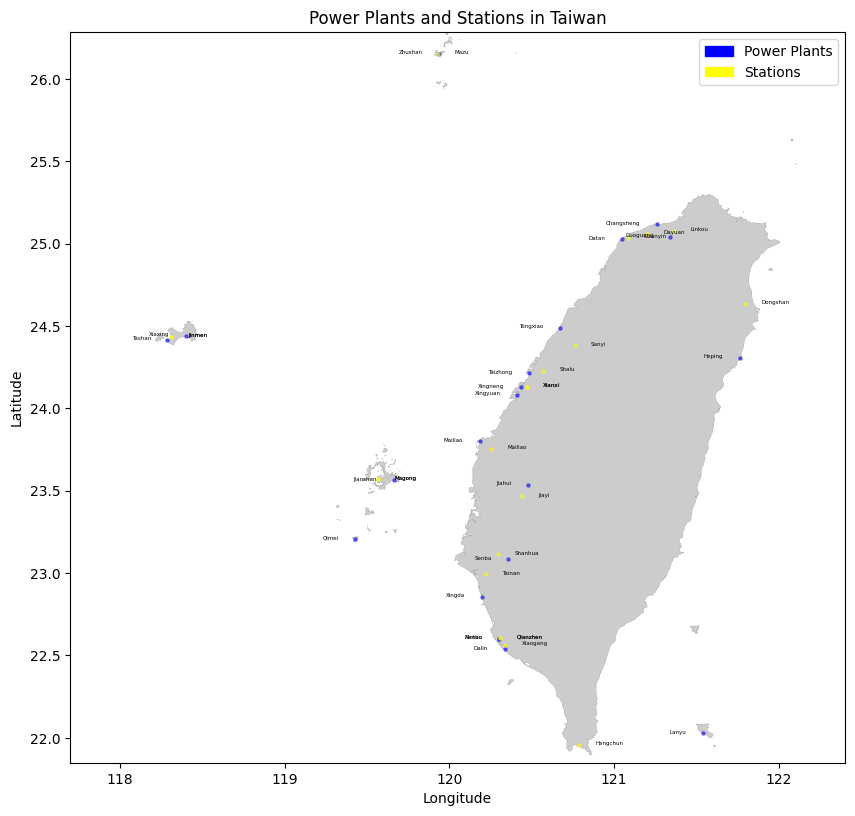

In [7]:
# plot the station/plant locations on the map

import geopandas as gpd
import matplotlib.patches as mpatches

# load processed data
data = pd.read_csv('.\\Plant Station Location_20230820.csv')
# load Taiwan map
taiwan = gpd.read_file('.\\TW Map\\gadm36_TWN_0.shp')

# Create a GeoDataFrame for power plants and stations
gdf_power_plants = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.power_plant_longitude, data.power_plant_latitude))
gdf_stations = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.station_longitude, data.station_latitude))

# Plot the map
fig, ax = plt.subplots(figsize=(10,10))
taiwan.plot(ax=ax, color='#CCCCCC', edgecolor='black', linewidth=0.05)
gdf_power_plants.plot(ax=ax, color='blue', alpha=0.5, markersize=5)
gdf_stations.plot(ax=ax, color='yellow', alpha=0.5, markersize=5)

# Annotate the power plants to the left of the marker
for x, y, label in zip(gdf_power_plants.geometry.x, gdf_power_plants.geometry.y, gdf_power_plants.power_plant_name_pinyin):
    ax.text(x - 0.1, y, label, fontsize=4, ha='right')

# Annotate the stations to the right of the marker
for x, y, label in zip(gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations.station_name_pinyin):
    ax.text(x + 0.1, y, label, fontsize=4, ha='left')

xmin, ymin, xmax, ymax = gpd.GeoSeries(pd.concat([gdf_power_plants.geometry, gdf_stations.geometry])).total_bounds
ax.set_xlim(xmin * 0.995, xmax * 1.005)
ax.set_ylim(ymin * 0.995, ymax * 1.005)

# Create the patches for the legend
blue_patch = mpatches.Patch(color='blue', label='Power Plants')
yellow_patch = mpatches.Patch(color='yellow', label='Stations')

ax.legend(handles=[blue_patch, yellow_patch])

# Set the plot title
plt.title("Power Plants and Stations in Taiwan")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()
fig.savefig('.\\map.png', dpi=600)


### Data Acquisition

#### Initialization & Helper Functions
The public database API has a limit of 1,000 entries per request, so we've implemented a script for automatic data acquisition. An API key is required for this process; please visit the link below to register for an API key.

[Ministry of Environment Database API Registration](https://data.moenv.gov.tw/en/paradigm)

In [9]:
import requests
import json
from datetime import timedelta, datetime

api_key = 'INSERT YOUR API KEY HERE'

# site id string preparation
plant_station_data = pd.read_csv('.\\Plant Station Location_20230820.csv')
site_list = plant_station_data['"siteid"'].to_list()
total_capacity = plant_station_data['capacity'].sum()


def fetch_data(site_id, start_date_str, end_date_str):
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    # num_sites = len(site_str.split(','))
    num_data = int((end_date - start_date).total_seconds() / 3600) 
    site_filter_str = f'siteid,EQ,{site_id}'
    time_filter_str = f'datacreationdate,GR,{start_date_str} 00:00:00|datacreationdate,LE,{end_date_str} 23:00:00'
    filter_str = f'{site_filter_str}|{time_filter_str}'
    fields_str = 'datacreationdate,site,sitename,aqi,so2_avg,pm2.5_avg,pm10_avg'
    url = f'https://data.epa.gov.tw/api/v2/aqx_p_488?format=json&offset=0&limit={num_data}&api_key={api_key}&filters={filter_str}&fields={fields_str}'
    response = requests.get(url)
    data = json.loads(response.content)
    return response, url, data

def get_record(data):
    record = pd.DataFrame(data['records'])
    record.drop('sitename', axis=1, inplace=True)
    record['datacreationdate'] = pd.to_datetime(record['datacreationdate'])
    record.set_index('datacreationdate', inplace=True)
    record['aqi'] = pd.to_numeric(record['aqi'], downcast='integer', errors='coerce')
    record['pm2.5_avg'] = pd.to_numeric(record['pm2.5_avg'], downcast='float', errors='coerce')
    record['pm10_avg'] = pd.to_numeric(record['pm10_avg'], downcast='float', errors='coerce')
    record['so2_avg'] = pd.to_numeric(record['so2_avg'], downcast='float', errors='coerce')
    return record

def get_all_data(site_id, start_date, end_date):
    # Convert strings to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")    
    # Max number of days for 1000 hourly data points
    MAX_DAYS = 41  # 1000 hours / 24 = 41.66 days    
    all_record_frames = []  # List to store dataframes from each fetch
    while start < end:
        # Calculate the next end date by adding MAX_DAYS, but ensure it doesn't exceed the user's end_date
        next_end = min(start + timedelta(days=MAX_DAYS), end)
        print(f'Getting data from {start.strftime("%Y-%m-%d")} to {next_end.strftime("%Y-%m-%d")}')
        # Fetch data for the current chunk
        _, _, data  = fetch_data(site_id, start.strftime("%Y-%m-%d"), next_end.strftime("%Y-%m-%d"))
        record = get_record(data)       
        all_record_frames.append(record)        
        # Move the start date for the next chunk
        start = next_end
    # Concatenate all the dataframes
    final_record = pd.concat(all_record_frames, axis=0)
    return final_record



#### Get Air Monitoring Data

The data of the fossil power related emission were collected and weighted according to the power generation capacity of the nearest power plant. The weighted data were then resampled on a monthly basis.

<AxesSubplot: xlabel='datacreationdate'>

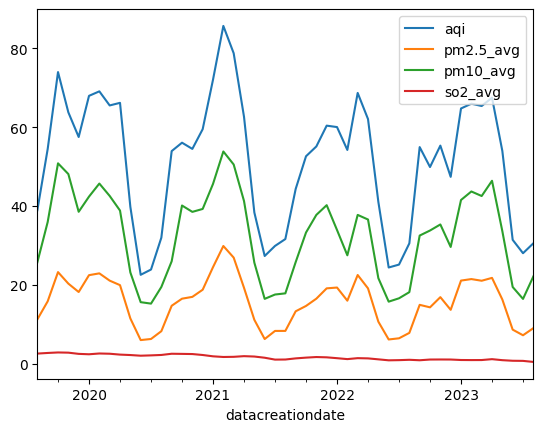

In [10]:
# data acquisition

# record_list = []

# for i, s in enumerate(site_list):
#     capacity = plant_station_data["capacity"][i]
#     plant_name = plant_station_data["power_plant_name"][i]
#     print(f'Getting data from {plant_name} (site_id: {s}, capacity: {capacity} MW)')
#     record = get_all_data(s, '2019-08-01', '2023-08-02')
#     record = record * capacity
#     site_name_eng = plant_station_data['"siteengname"'][i]
#     plant_name_eng = plant_station_data['power_plant_name_pinyin'][i]
#     record_fn = f'{plant_name_eng}_{site_name_eng}'
#     record.to_csv(f'.\\Data\\{record_fn}.csv')
#     record_list.append(record)

# read local data instead
record_list = []

for i, s in enumerate(site_list):      
    site_name_eng = plant_station_data['"siteengname"'][i]
    plant_name_eng = plant_station_data['power_plant_name_pinyin'][i]
    record_fn = f'{plant_name_eng}_{site_name_eng}'
    record = pd.read_csv(f'.\\Data\\{record_fn}.csv')
    record['datacreationdate'] = pd.to_datetime(record['datacreationdate'])
    record.set_index('datacreationdate', inplace=True)    
    record_list.append(record)

# remove duplicated entries & sort data

record_list_processed = []

for r in record_list:
    r_processed = r[~r.index.duplicated(keep='first')]
    r_processed = r_processed.sort_index()
    record_list_processed.append(r_processed)

# summation of all collected data and weighted by capacity

record_sum = record_list_processed[0].copy()

for i in range(len(record_list_processed[1:])):
    record_sum = record_sum.add(record_list_processed[i + 1], fill_value=0)

record_sum = record_sum / total_capacity

record_avg = record_sum.resample('M').mean()
record_avg.plot()

#### Get Power Data

<AxesSubplot: xlabel='date'>

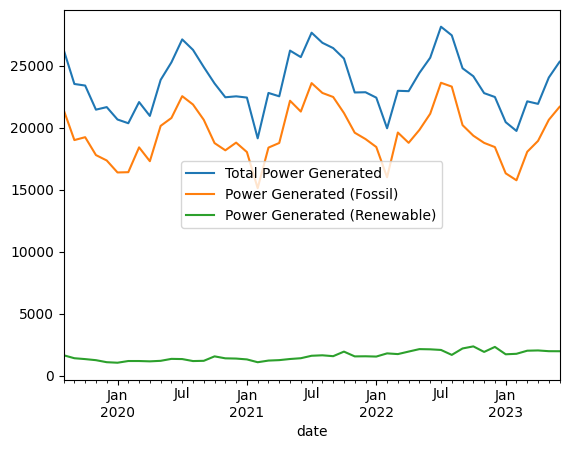

In [13]:
plant_station_data = pd.read_csv('.\\Plant Station Location_20230812.csv')
power_data = pd.read_csv('.\\Power Data_20230827.csv')
plant_power_data = pd.read_csv('.\\Power Plant Locations.csv')
# index parsing & data screening
power_data.set_index('日期(年/月)', inplace=True)
power_data.index = pd.to_datetime(power_data.index, format='%Y%m')
power_data = power_data[['全國發電量_總計', '全國發電量_火力_合計', '全國發電量_再生能源_合計']]
power_data.rename(columns={'全國發電量_總計':'Total Power Generated', '全國發電量_火力_合計':'Power Generated (Fossil)', '全國發電量_再生能源_合計':'Power Generated (Renewable)'}, inplace=True)
power_data.index.name = 'date'
power_data_avg = power_data['2019-08-01':'2023-06-01'].resample('M').mean()
power_data_avg.plot()


### Data Visualization

#### Power Data

The data indicates that Taiwan's primary source of power generation is fossil fuels while renewable is growing.

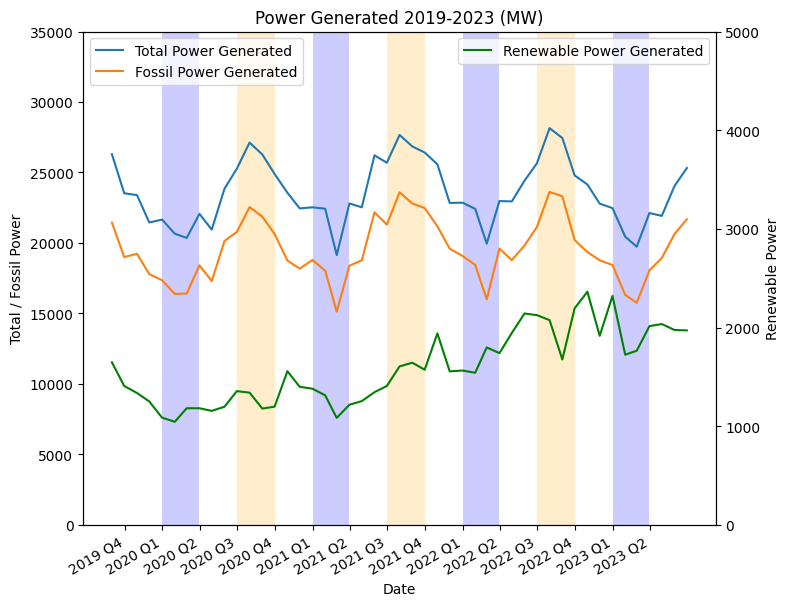

In [19]:

def format_to_quarter(dt):
    quarter = (dt.month - 1) // 3 + 1
    return f"{dt.year} Q{quarter}"

index = pd.to_datetime(power_data_avg.index)

fig, ax1 = plt.subplots()
fig.set_size_inches((8, 6))

ax1.plot(index, power_data_avg['Total Power Generated'], label='Total Power Generated')
ax1.plot(index, power_data_avg['Power Generated (Fossil)'], label='Fossil Power Generated')
# ax1.plot(index, power_data_avg['Power Generated (Renewable)'], label='Renewable Power Generated')

ax2 = ax1.twinx()
ax2.plot(index, power_data_avg['Power Generated (Renewable)'], label='Renewable Power Generated', color='green')

annual_dates = pd.date_range(start='2019-08-01', end='2023-06-01', freq='QS')

quarter_labels = [format_to_quarter(dt) for dt in annual_dates]

ax1.set_xticks(annual_dates)
# ax2.set_xticklabels(annual_dates.strftime('%Y-%m-%d'))
ax1.set_xticklabels(quarter_labels)

# Define colors for each season
season_colors = {
    1: 'blue',  # Q1 - Spring
    2: 'white',   # Q2 - Summer
    3: 'orange',      # Q3 - Autumn
    4: 'white'    # Q4 - Winter
}

# Colorize the background for each season
for start_date in annual_dates:
    quarter = (start_date.month - 1) // 3 + 1
    end_date = (start_date + pd.offsets.QuarterEnd())
    ax1.axvspan(start_date, end_date, facecolor=season_colors[quarter], alpha=0.2)


fig.autofmt_xdate()  # Automatically adjust the date labels
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set custom date format

# Setting labels, title, and legends
ax1.set_ylim((0, 35000))
ax2.set_ylim((0, 5000))
ax1.set_xlabel('Date')
ax1.set_ylabel(('Total / Fossil Power'))
ax2.set_ylabel(('Renewable Power'))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Power Generated 2019-2023 (MW)')
plt.savefig('.\\power.png', dpi=300)

plt.show()


#### Air Quality Data

The plot shows seasonal periodic changes in particulate matter emission (PM), which is not present in $SO_2$. The seasonal change suggests a meteorological cause of PM emission.

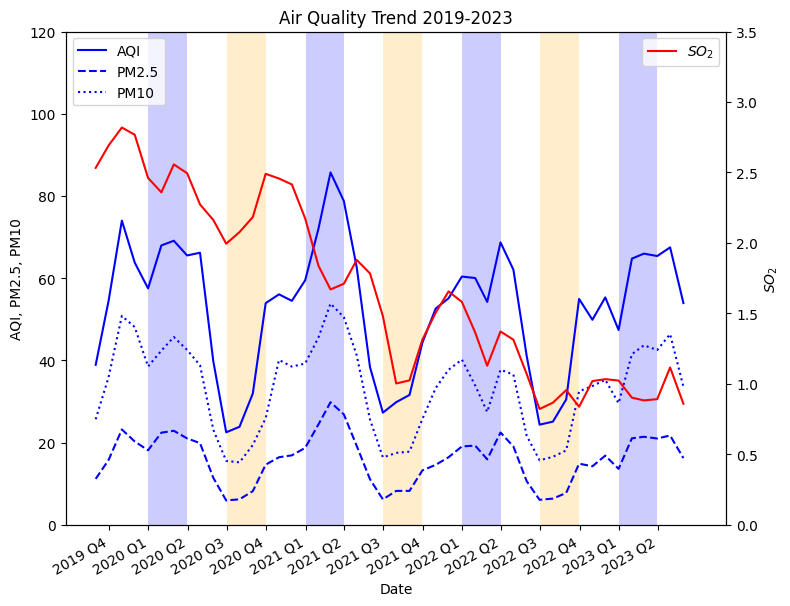

In [20]:
# air data
record_avg = pd.read_csv('.\\plant_station_record_avg.csv')
record_avg.set_index('datacreationdate', inplace=True)
record_avg = record_avg['2019-08-01':'2023-06-01']

# air data analysis
import matplotlib.dates as mdates

data_list = list(record_avg.columns[0:-1])

colors = {
    'aqi': 'blue',
    'pm2.5_avg': 'blue',
    'pm10_avg': 'blue',
    'so2_avg': 'red'
}
linestyles = {
    'aqi': '-',
    'pm2.5_avg': '--',
    'pm10_avg': ':',
    'so2_avg': '-'
}

labels = {
    'aqi': 'AQI',
    'pm2.5_avg': 'PM2.5',
    'pm10_avg': 'PM10',
    'so2_avg': '$SO_2$'
}

def format_to_quarter(dt):
    quarter = (dt.month - 1) // 3 + 1
    return f"{dt.year} Q{quarter}"

index = pd.to_datetime(record_avg.index)

fig, ax1 = plt.subplots()
fig.set_size_inches((8, 6))
ax1.set_ylim(0, 120)
for c in data_list:
    ax1.plot(index, record_avg[c], color=colors[c], linestyle=linestyles[c], label=labels[c])

# Create a second y-axis for 'd' and plot it
ax2 = ax1.twinx()
ax2.set_ylim(0, 3.5)
ax2.plot(index, record_avg['so2_avg'], color=colors['so2_avg'], linestyle=linestyles['so2_avg'], label=labels['so2_avg'])

annual_dates = pd.date_range(start='2019-08-01', end='2023-06-01', freq='QS')

quarter_labels = [format_to_quarter(dt) for dt in annual_dates]

ax2.set_xticks(annual_dates)
# ax2.set_xticklabels(annual_dates.strftime('%Y-%m-%d'))
ax2.set_xticklabels(quarter_labels)

# Define colors for each season
season_colors = {
    1: 'blue',  # Q1 - Spring
    2: 'white',   # Q2 - Summer
    3: 'orange',      # Q3 - Autumn
    4: 'white'    # Q4 - Winter
}

# Colorize the background for each season
for start_date in annual_dates:
    quarter = (start_date.month - 1) // 3 + 1
    end_date = (start_date + pd.offsets.QuarterEnd())
    ax1.axvspan(start_date, end_date, facecolor=season_colors[quarter], alpha=0.2)


fig.autofmt_xdate()  # Automatically adjust the date labels
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set custom date format

# Setting labels, title, and legends
ax1.set_ylabel('AQI, PM2.5, PM10')
ax2.set_ylabel('$SO_2$')
ax1.set_xlabel('Date')
ax2.legend(loc='upper right')
ax1.legend(loc='upper left')

fig.tight_layout()
plt.title('Air Quality Trend 2019-2023')
plt.savefig('.\\air_trend.png', dpi=300)

plt.show()

#### Fossil Power Generation vs. Air Quality

The peak in PM occurs when fossil power generation is at its lowest, suggesting fossil power may not be the main source of these PM emission.

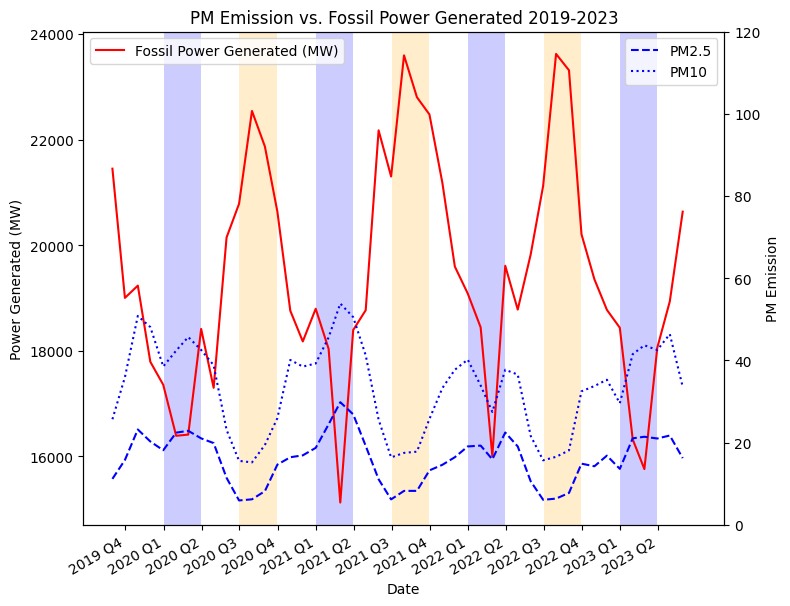

In [23]:
# pm2.5/10 data vs. power data

data_list = list(record_avg.columns[0:-1])

colors = {
    'aqi': 'blue',
    'pm2.5_avg': 'blue',
    'pm10_avg': 'blue',
    'so2_avg': 'red'
}
linestyles = {
    'aqi': '-',
    'pm2.5_avg': '--',
    'pm10_avg': ':',
    'so2_avg': '-'
}

labels = {
    'aqi': 'AQI',
    'pm2.5_avg': 'PM2.5',
    'pm10_avg': 'PM10',
    'so2_avg': '$SO_2$'
}

def format_to_quarter(dt):
    quarter = (dt.month - 1) // 3 + 1
    return f"{dt.year} Q{quarter}"

index = pd.to_datetime(record_avg.index)

fig, ax1 = plt.subplots()
fig.set_size_inches((8, 6))

ax1.plot(index, power_data_avg['Power Generated (Fossil)'][0:-1], label='Fossil Power Generated (MW)', color='red')
# ax1.plot(index, power_data_avg['Power Generated (Fossil)'][0:-1], label='Total Power Fossil (MW)')
# ax1.plot(index, power_data_avg['Power Generated (Renewable)'][0:-1], label='Total Power Renewable (MW)')


# Create a second y-axis for 'd' and plot it
ax2 = ax1.twinx()
ax2.set_ylim(0, 120)
ax2.plot(index, record_avg['pm2.5_avg'], color=colors['pm2.5_avg'], linestyle=linestyles['pm2.5_avg'], label=labels['pm2.5_avg'])
ax2.plot(index, record_avg['pm10_avg'], color=colors['pm10_avg'], linestyle=linestyles['pm10_avg'], label=labels['pm10_avg'])
# ax2.plot(index, record_avg['aqi'], color=colors['aqi'], linestyle=linestyles['aqi'], label=labels['aqi'])


annual_dates = pd.date_range(start='2019-08-01', end='2023-06-01', freq='QS')

quarter_labels = [format_to_quarter(dt) for dt in annual_dates]

ax2.set_xticks(annual_dates)
# ax2.set_xticklabels(annual_dates.strftime('%Y-%m-%d'))
ax2.set_xticklabels(quarter_labels)

# Define colors for each season
season_colors = {
    1: 'blue',  # Q1 - Spring
    2: 'white',   # Q2 - Summer
    3: 'orange',      # Q3 - Autumn
    4: 'white'    # Q4 - Winter
}

# Colorize the background for each season
for start_date in annual_dates:
    quarter = (start_date.month - 1) // 3 + 1
    end_date = (start_date + pd.offsets.QuarterEnd())
    ax1.axvspan(start_date, end_date, facecolor=season_colors[quarter], alpha=0.2)


fig.autofmt_xdate()  # Automatically adjust the date labels
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set custom date format

# Setting labels, title, and legends
ax1.set_ylabel('Power Generated (MW)')
ax2.set_ylabel('PM Emission')
ax1.set_xlabel('Date')
ax2.legend(loc='upper right')
ax1.legend(loc='upper left')

fig.tight_layout()
plt.title('PM Emission vs. Fossil Power Generated 2019-2023')
plt.savefig('.\\particle_fossil.png', dpi=300)

plt.show()

The decrease in $SO_2$ level, coupled with the slowly increase in fossil power generation indicate the improvement of the fossil power generator in recent years.

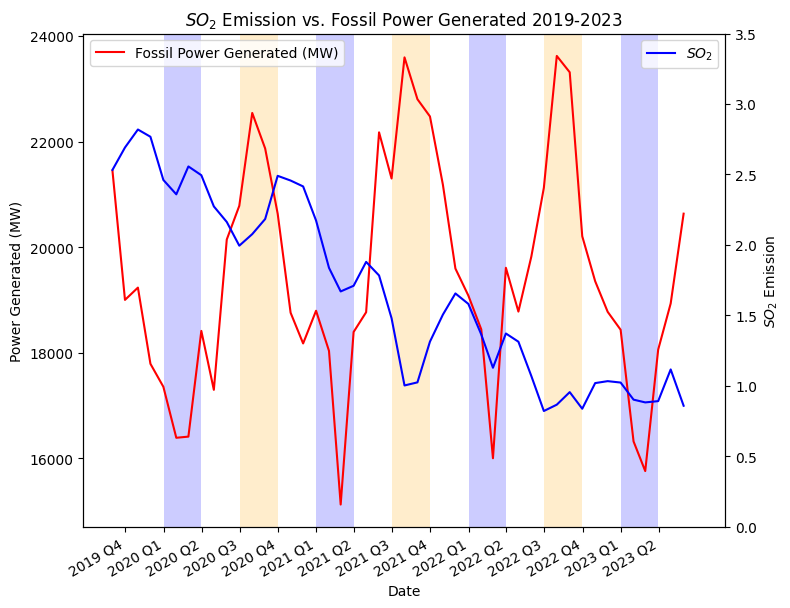

In [24]:
# so2 data vs. power data

data_list = list(record_avg.columns[0:-1])

colors = {
    'aqi': 'blue',
    'pm2.5_avg': 'blue',
    'pm10_avg': 'blue',
    'so2_avg': 'blue'
}
linestyles = {
    'aqi': '-',
    'pm2.5_avg': '--',
    'pm10_avg': ':',
    'so2_avg': '-'
}

labels = {
    'aqi': 'AQI',
    'pm2.5_avg': 'PM2.5',
    'pm10_avg': 'PM10',
    'so2_avg': '$SO_2$'
}

def format_to_quarter(dt):
    quarter = (dt.month - 1) // 3 + 1
    return f"{dt.year} Q{quarter}"

index = pd.to_datetime(record_avg.index)

fig, ax1 = plt.subplots()
fig.set_size_inches((8, 6))

ax1.plot(index, power_data_avg['Power Generated (Fossil)'][0:-1], label='Fossil Power Generated (MW)', color='red')
# ax1.plot(index, power_data_avg['Power Generated (Fossil)'][0:-1], label='Total Power Fossil (MW)')
# ax1.plot(index, power_data_avg['Power Generated (Renewable)'][0:-1], label='Total Power Renewable (MW)')


# Create a second y-axis for 'd' and plot it
ax2 = ax1.twinx()
ax2.set_ylim(0, 3.5)
ax2.plot(index, record_avg['so2_avg'], color=colors['so2_avg'], linestyle=linestyles['so2_avg'], label=labels['so2_avg'])

annual_dates = pd.date_range(start='2019-08-01', end='2023-06-01', freq='QS')

quarter_labels = [format_to_quarter(dt) for dt in annual_dates]

ax2.set_xticks(annual_dates)
# ax2.set_xticklabels(annual_dates.strftime('%Y-%m-%d'))
ax2.set_xticklabels(quarter_labels)

# Define colors for each season
season_colors = {
    1: 'blue',  # Q1 - Spring
    2: 'white',   # Q2 - Summer
    3: 'orange',      # Q3 - Autumn
    4: 'white'    # Q4 - Winter
}

# Colorize the background for each season
for start_date in annual_dates:
    quarter = (start_date.month - 1) // 3 + 1
    end_date = (start_date + pd.offsets.QuarterEnd())
    ax1.axvspan(start_date, end_date, facecolor=season_colors[quarter], alpha=0.2)


fig.autofmt_xdate()  # Automatically adjust the date labels
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set custom date format

# Setting labels, title, and legends
ax1.set_ylabel('Power Generated (MW)')
ax2.set_ylabel('$SO_2$ Emission')
ax1.set_xlabel('Date')
ax2.legend(loc='upper right')
ax1.legend(loc='upper left')

fig.tight_layout()
plt.title('$SO_2$ Emission vs. Fossil Power Generated 2019-2023')
plt.savefig('.\\so2_fossil.png', dpi=300)
plt.show()

### Conclusion
In this study, we investigate the relationship between fossil power generation and various types of air pollutants. Our findings indicate a strong seasonal pattern in particulate matter (PM) emissions, which negatively correlate with fossil power generation. This suggests that fossil power plants may not be the primary source of PM emissions, and the seasonal variations could be attributed to meteorological phenomena such as monsoons.

The observed decline in $SO_2$ emissions, in conjunction with the gradual increase in fossil power generation, points to improvements in the efficiency and environmental performance of existing power plants.